#### Import Libraries

In [69]:
import pandas as pd
import yaml
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np

#### Helper Functions

In [70]:
def load_config():
    with open("config.yml", 'r') as file:
        return yaml.safe_load(file)

In [71]:
def create_db_engine(db_config):
    db_url = f"postgresql+psycopg2://{db_config['uid']}:{db_config['pwd']}@{db_config['server']}:{db_config['port']}/{db_config['database']}"
    return create_engine(db_url)

In [72]:
def load_data(engine, query):
    with engine.connect() as connection:
        return pd.read_sql(query, connection)

In [73]:
def aggregate_columns(df, aggregation_map):
    for new_col, cols_to_sum in aggregation_map.items():
        df[cols_to_sum] = df[cols_to_sum].apply(pd.to_numeric, errors='coerce').fillna(0)
        df[new_col] = df[cols_to_sum].sum(axis=1)
    return df

In [74]:
def calculate_exclusion_ratio(
        df,
        suspension_cols,
        enrollment_col,
        new_col_name,
        missing_data_value=None
    ):
    """
    Calculates the ratio of disciplinary actions to total enrollment for given columns.

    Parameters:
    - df: DataFrame to operate on.
    - suspension_cols: List of columns representing counts of disciplinary actions.
    - enrollment_col: Column name for enrollment data.
    - new_col_name: Name of the new column for the calculated ratio.
    - missing_data_value: Value to assign if calculation cannot be performed.

    Returns:
    - Modified DataFrame with the new ratio column.
    """

    df = df.copy()

    df.loc[:, suspension_cols] = df[suspension_cols].apply(pd.to_numeric, errors='coerce')
    df.loc[:, enrollment_col] = pd.to_numeric(df[enrollment_col], errors='coerce')

    df[new_col_name] = missing_data_value

    for idx, row in df.iterrows():
        if pd.isnull(row[enrollment_col]) or row[enrollment_col] <= 0:
            df.loc[idx, new_col_name] = missing_data_value
        else:
            disciplinary_action_count = row[suspension_cols].sum(skipna=True)
            df.loc[idx, new_col_name] = disciplinary_action_count / row[enrollment_col]

    return df

In [75]:
def calculate_violent_inc_ratio(
        df,
        numerator_cols,
        enrollment_col,
        new_col_name,
        missing_data_value=None
    ):
    """
    Calculates the ratio of violent incidents to total enrollment for given columns.
    
    Parameters:
    - df: DataFrame to operate on.
    - numerator_cols: List of columns representing counts of violent incidents.
    - enrollment_col: Column name for enrollment data.
    - new_col_name: Name of the new column for the calculated ratio.
    - missing_data_value: Value to assign if calculation cannot be performed.

    Returns:
    - Modified DataFrame with the new ratio column.
    """

    df = df.copy()

    df.loc[:, numerator_cols] = df[numerator_cols].apply(pd.to_numeric, errors='coerce')
    df.loc[:, enrollment_col] = pd.to_numeric(df[enrollment_col], errors='coerce')

    df[new_col_name] = missing_data_value

    for idx, row in df.iterrows():
        if pd.isnull(row[enrollment_col]) or row[enrollment_col] <= 0:
            df.loc[idx, new_col_name] = missing_data_value
        else:
            violence_incidents_count = row[numerator_cols].sum(skipna=True)
            df.loc[idx, new_col_name] = violence_incidents_count / row[enrollment_col]

    return df

In [76]:
def calculate_disciplinary_to_violence_ratio(
    df,
    disciplinary_cols,
    violence_cols,
    new_col_name,
    missing_data_value=None
):
    """
    Calculates the ratio of disciplinary actions to violent incidents for given columns.

    Parameters:
    - df: DataFrame to operate on.
    - disciplinary_cols: List of columns representing counts of disciplinary actions.
    - violence_cols: List of columns representing counts of violent incidents.
    - new_col_name: Name of the new column for the calculated ratio.
    - missing_data_value: Value to assign if calculation cannot be performed.

    Returns:
    - Modified DataFrame with the new ratio column.
    """
    df = df.copy()

    df.loc[:, disciplinary_cols] = df[disciplinary_cols].apply(pd.to_numeric, errors='coerce')
    df.loc[:, violence_cols] = df[violence_cols].apply(pd.to_numeric, errors='coerce')

    df[new_col_name] = missing_data_value

    for idx, row in df.iterrows():
        disciplinary_action_count = row[disciplinary_cols].sum(skipna=True)
        violence_incidents_count = row[violence_cols].sum(skipna=True)

        if pd.isnull(violence_incidents_count) or violence_incidents_count <= 0:
            df.loc[idx, new_col_name] = missing_data_value
        else:
            df.loc[idx, new_col_name] = disciplinary_action_count / violence_incidents_count

    return df

In [77]:
def count_schools_by_quantile(df, column, quantiles, column_label="quantile"):
    """
    Calculates the number of schools in each quantile for a given column using
    precomputed quantiles.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        column (str): The column for which quantile counts are calculated.
        quantiles (Series): Precomputed quantile values.
        column_label (str): The name of the new column to store quantile labels.

    Returns:
        DataFrame: A DataFrame with quantile ranges and counts.
    """

    quantile_labels = [f"Q{i+1}" for i in range(len(quantiles) - 1)]

    df[column] = pd.to_numeric(df[column], errors='coerce')
    df = df.dropna(subset=[column])

    df[column_label] = pd.cut(
        df[column], bins=quantiles, labels=quantile_labels, include_lowest=True
    )

    quantile_counts = (
        df.groupby(column_label, observed=False)
          .size()
          .reset_index(name="school_count")
    )

    quantile_ranges = [
        f"[{quantiles[i]:.2f}, {quantiles[i+1]:.2f}]" for i in range(len(quantiles))
    ]

    quantile_summary = pd.DataFrame({
        "quantile": quantile_labels,
        "quantile_range": quantile_ranges,
        "school_count": quantile_counts["school_count"].values
    })

    return quantile_summary

In [78]:
def generate_histograms(report_card_df, rssi_schools_df):
    fig, axes = plt.subplots(2, 2, figsize=(14, 18))
    fig.suptitle(
        'Histograms for Disciplinary Action and Violent Incidents',
        fontsize=16
    )

    # All Schools: Disciplinary Action Ratio
    axes[0, 0].hist(
        report_card_df['disciplinary_action_ratio'].dropna(), bins=10,
        color='blue', edgecolor='black', alpha=0.7
    )
    axes[0, 0].set_title("All Schools - Disciplinary Action Ratio")
    axes[0, 0].set_xlabel("Ratio")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # All Schools: Violent Incidents Ratio
    axes[0, 1].hist(
        report_card_df['violent_incidents_ratio'].dropna(), bins=10, color='red',
        edgecolor='black', alpha=0.7
    )
    axes[0, 1].set_title("All Schools - Violent Incidents Ratio")
    axes[0, 1].set_xlabel("Ratio")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # RSSI Schools: Disciplinary Action Ratio
    axes[1, 0].hist(
        rssi_schools_df['disciplinary_action_ratio'].dropna(), bins=10,
        color='green', edgecolor='black', alpha=0.7
    )
    axes[1, 0].set_title("RSSI Schools - Disciplinary Action Ratio")
    axes[1, 0].set_xlabel("Ratio")
    axes[1, 0].set_ylabel("Frequency")
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # RSSI Schools: Violent Incidents Ratio
    axes[1, 1].hist(
        rssi_schools_df['violent_incidents_ratio'].dropna(), bins=10, color='purple',
        edgecolor='black', alpha=0.7
    )
    axes[1, 1].set_title("RSSI Schools - Violent Incidents Ratio")
    axes[1, 1].set_xlabel("Ratio")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

#### Load the configuration and establish the database connection

In [79]:
config = load_config()
db_config = config['rssi-data-warehouse']['dataconnection']
engine = create_db_engine(db_config)

#### Define the queries and load the data

In [80]:
REPORT_CARD_QUERY = """
SELECT rcdts, num_stdnt_enrlmnt
FROM report_card
"""

REPORT_CARD_DISC_QUERY = """
SELECT rcdts, isbe_type, school_name, district, 
    num_stdnts_with_discipline_incidents,
    num_disc_incdts_viol_harm, num_disc_incdts_viol_noharm, 
    num_disc_incdts_firearm, num_disc_incdts_oth_wpn
FROM report_card_disc
"""

RSSI_COHORTS_QUERY = """
SELECT rcdts
FROM rssi_cohorts
"""

report_card_df = load_data(engine, REPORT_CARD_QUERY)
report_card_disc_df = load_data(engine, REPORT_CARD_DISC_QUERY)
rssi_cohorts_df = load_data(engine, RSSI_COHORTS_QUERY)

#### Merge dataframes & aggregate columns

In [81]:
report_card_df = pd.merge(report_card_df, report_card_disc_df, on='rcdts', how='inner')

aggregation_map_disc = {
    'num_disc_incdts_violent': [
        'num_disc_incdts_viol_harm', 'num_disc_incdts_viol_noharm'
    ],
    'num_disc_incdts_other': [
        'num_disc_incdts_firearm', 'num_disc_incdts_oth_wpn'
    ]
}
report_card_df = aggregate_columns(report_card_df, aggregation_map_disc)

#### Calculate and describe ratios

The data reveals that, on average, the **disciplinary action ratio** across the 18,781 schools is relatively low, with a mean of 0.05 and a standard deviation of 0.07. This suggests that most schools have a small proportion of students involved in disciplinary actions. The distribution of this ratio is skewed, with the 25th percentile at 0.01 and the 75th percentile at 0.07, indicating that the majority of schools report minimal disciplinary incidents. However, the maximum value of 0.77 suggests that there are a small number of schools experiencing significantly higher disciplinary actions, creating a considerable spread in the data.

In contrast, the **violent incidents ratio** has a much higher mean of 0.59 and a similar standard deviation of 0.58, indicating greater variability in the frequency of violent incidents. The data is more spread out, with the 25th percentile at 0.12 and the 75th percentile at 0.93, implying that many schools report a relatively small number of violent incidents, but a significant proportion of schools experience much higher rates. The maximum value of 6.00, a considerable outlier, suggests that there are a few schools with exceptionally high rates of violent incidents. This highlights that while violent incidents may be rare in many schools, a small number of schools have disproportionately high occurrences.

Filter RSSI schools

In [82]:
report_card_df = calculate_exclusion_ratio(
    report_card_df, ['num_stdnts_with_discipline_incidents'],
    'num_stdnt_enrlmnt', 'disciplinary_action_ratio'
)

report_card_df = calculate_violent_inc_ratio(
    report_card_df, ['num_disc_incdts_violent', 'num_disc_incdts_other'],
    'num_stdnts_with_discipline_incidents', 'violent_incidents_ratio'
)

report_card_df['disciplinary_action_ratio'] = pd.to_numeric(
    report_card_df['disciplinary_action_ratio'], errors='coerce'
)
report_card_df['violent_incidents_ratio'] = pd.to_numeric(
    report_card_df['violent_incidents_ratio'], errors='coerce'
)

rssi_rcdts = rssi_cohorts_df['rcdts']
rssi_schools_df = report_card_df[report_card_df['rcdts'].isin(rssi_rcdts)]

rssi_schools_df = calculate_exclusion_ratio(
    rssi_schools_df, ['num_stdnts_with_discipline_incidents'],
    'num_stdnt_enrlmnt', 'disciplinary_action_ratio'
)

rssi_schools_df = calculate_violent_inc_ratio(
    rssi_schools_df, ['num_disc_incdts_violent', 'num_disc_incdts_other'],
    'num_stdnts_with_discipline_incidents', 'violent_incidents_ratio'
)

rssi_schools_df['disciplinary_action_ratio'] = pd.to_numeric(
    rssi_schools_df['disciplinary_action_ratio'], errors='coerce'
)
rssi_schools_df['violent_incidents_ratio'] = pd.to_numeric(
    rssi_schools_df['violent_incidents_ratio'], errors='coerce'
)

report_card_df['source'] = 'All Schools'
rssi_schools_df['source'] = 'RSSI Schools'

combined_df = pd.concat([
    report_card_df[['source', 'disciplinary_action_ratio', 'violent_incidents_ratio']],
    rssi_schools_df[['source', 'disciplinary_action_ratio', 'violent_incidents_ratio']]
])

summary_table = (
    combined_df.groupby('source')[['disciplinary_action_ratio', 'violent_incidents_ratio']]
               .describe()
               .round(3)
               .stack()
               .unstack(level=0)
)

summary_table

C:\Users\RobertSurridge\AppData\Local\Temp\ipykernel_49816\587006452.py:50: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack()


disciplinary_action_ratio              violent_incidents_ratio  \
source               All Schools RSSI Schools             All Schools   
count                  18781.000     1413.000               15650.000   
mean                       0.053        0.058                   0.589   
std                        0.071        0.070                   0.578   
min                        0.000        0.000                   0.000   
25%                        0.006        0.010                   0.125   
50%                        0.029        0.034                   0.500   
75%                        0.072        0.079                   0.933   
max                        0.767        0.639                   6.000   

                     
source RSSI Schools  
count      1229.000  
mean          0.550  
std           0.554  
min           0.000  
25%           0.077  
50%           0.455  
75%           0.860  
max           4.647

When analyzing the **RSSI schools** subset, we observe some similarities and differences compared to the overall school population. The **disciplinary action ratio** for RSSI schools has a mean of 0.06 and a standard deviation of 0.07, which is slightly higher than the mean for all schools (0.05). The spread of this ratio in RSSI schools is comparable to all schools, with the 25th percentile at 0.01 and the 75th percentile at 0.08, showing that most RSSI schools also report low disciplinary incidents. However, the maximum value for RSSI schools is 0.64, which is lower than the maximum of 0.77 observed for all schools, indicating fewer extreme cases in this subset.

For **violent incidents**, the mean for RSSI schools is 0.55, slightly lower than the 0.59 observed for all schools, with a standard deviation of 0.56. The spread of this ratio in RSSI schools is also noticeable: the 25th percentile is at 0.08, and the 75th percentile is at 0.86, which indicates a higher concentration of schools with violent incident ratios closer to the higher end of the distribution, compared to all schools. The maximum value of 4.65, while lower than the all-schools maximum of 6.00, still represents a significant outlier, showing that while most RSSI schools report low rates of violent incidents, a subset has notably higher rates. The distribution of violent incidents in RSSI schools appears slightly more skewed than that for all schools.

#### Create quantiles table

In [83]:
all_schools_disciplinary_quantiles = (
    report_card_df['disciplinary_action_ratio'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
                                               .round(3)
)
all_schools_violent_quantiles = (
    report_card_df['violent_incidents_ratio'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
                                             .round(3)
)
rssi_disciplinary_quantiles = (
    rssi_schools_df['disciplinary_action_ratio'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
                                                .round(3)
)
rssi_violent_quantiles = (
    rssi_schools_df['violent_incidents_ratio'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
                                              .round(3)
)

columns = pd.MultiIndex.from_product(
    [
        ['Disciplinary Action Ratio', 'Violent Incidents Ratio'],
        ['All Schools', 'RSSI Schools'],
    ],
    names=['Metric', 'School Type']
)

quantiles_table = pd.DataFrame(
    data=np.array([
        all_schools_disciplinary_quantiles.values,
        rssi_disciplinary_quantiles.values,
        all_schools_violent_quantiles.values,
        rssi_violent_quantiles.values

    ]).T,
    columns=columns,
    index=all_schools_disciplinary_quantiles.index
)

quantiles_table.index.name = 'Quantile'

display(quantiles_table)

Metric      Disciplinary Action Ratio              Violent Incidents Ratio  \
School Type               All Schools RSSI Schools             All Schools   
Quantile                                                                     
0.0                             0.000        0.000                   0.000   
0.2                             0.003        0.007                   0.051   
0.4                             0.018        0.024                   0.333   
0.6                             0.043        0.047                   0.639   
0.8                             0.088        0.099                   1.000   
1.0                             0.767        0.639                   6.000   

Metric                    
School Type RSSI Schools  
Quantile                  
0.0                0.000  
0.2                0.017  
0.4                0.286  
0.6                0.579  
0.8                1.000  
1.0                4.647

For the **disciplinary action ratio**, both groups show low median values (0.018 for all schools and 0.025 for RSSI schools), indicating that the majority of schools have relatively low disciplinary actions. However, the 80th and 100th percentiles for all schools are slightly higher than those for RSSI schools, suggesting that a subset of all schools exhibits more extreme ratios of disciplinary actions compared to RSSI schools.

In terms of the **violent incidents ratio**, the data indicates greater variability. The median ratio for all schools (0.333) is higher than for RSSI schools (0.286), showing that violent incidents are somewhat more common in all schools. However, the maximum ratio for all schools (6.0) exceeds that of RSSI schools (4.65), suggesting that extreme cases of violence are more frequent in the broader school population. Both distributions are skewed, as evidenced by higher values in the upper quantiles, but RSSI schools exhibit less extreme outliers. These findings may indicate differing behavioral trends or reporting practices between the two groups.

#### Create histograms

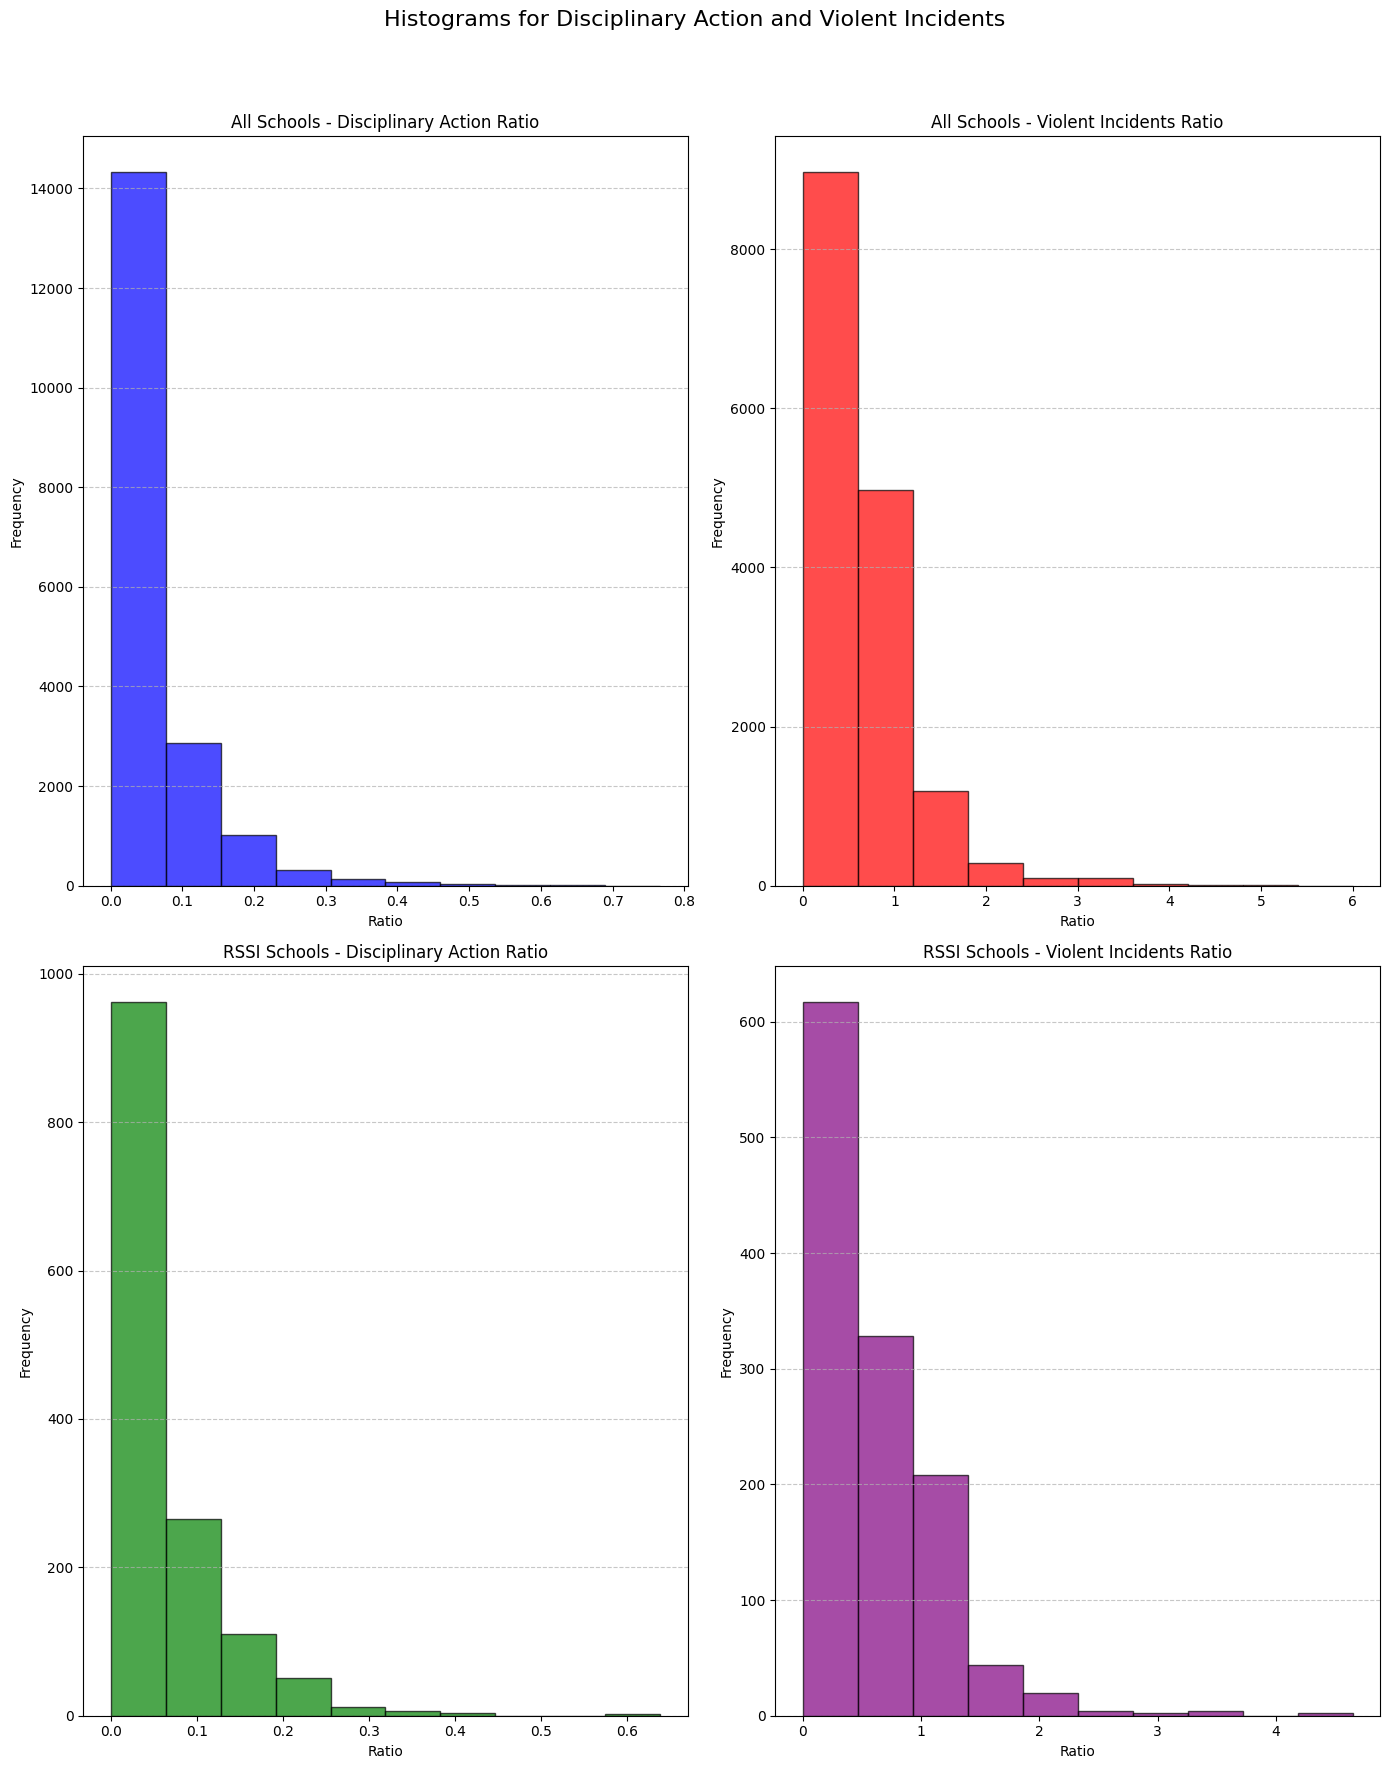

In [84]:
generate_histograms(report_card_df, rssi_schools_df)

In [85]:
def normalize_scores(df, column, bin_size):
    """
    Normalize a given column to a 100-point scale and categorize into bins.

    Args:
        df (pd.DataFrame): The input dataframe.
        column (str): The column to normalize and categorize.
        bin_size (int): The bin size (5 or 10).

    Returns:
        pd.DataFrame: The dataframe with an additional column for normalized scores.
    """
    new_df = df.copy()
    max_ratio = df[column].max()
    min_ratio = df[column].min()
    
    new_df[column + f'_score_normal_{bin_size}'] = 100 * ((new_df[column] - min_ratio) / (max_ratio - min_ratio))

    bins = list(range(0, 101, bin_size)) + [float('inf')]
    labels = list(range(0, 101, bin_size))

    new_df[column + f'_score_normal_{bin_size}'] = pd.cut(
        new_df[column + f'_score_normal_{bin_size}'], bins=bins, labels=labels[::-1], right=False, include_lowest=True
    )

    return new_df

def custom_score(df, column, custom_bins_scores, bin_size):
    """
    Calculate custom scores based on bins and scores for a specific column.

    Args:
        df (pd.DataFrame): The input dataframe.
        column (str): The column to calculate scores for.
        custom_bins_scores (dict): A dictionary with 'bins' and 'scores'.

    Returns:
        pd.DataFrame: The dataframe with an additional column for custom scores.
    """
    new_df = df.copy()
    bins = custom_bins_scores[column]['bins']
    scores = custom_bins_scores[column]['scores']

    new_df[column + f'_score_custom_{bin_size}'] = pd.cut(new_df[column], bins=bins, labels=scores, right=True)
    new_df = new_df.dropna(subset=[column + f'_score_custom_{bin_size}'])
    new_df.loc[:, column + f'_score_custom_{bin_size}'] = new_df.loc[:, column + f'_score_custom_{bin_size}'].astype(float)

    return new_df

def quantile_scores(df, column, bin_size):
    """
    Determine the quantile scores for a given column.

    Args:
        df (pd.DataFrame): The input dataframe.
        column (str): The column name for which to calculate quantiles.
        bin_size (int): The bin size to use (5 or 10).

    Returns:
        pd.DataFrame: The dataframe with an additional column for quantile scores.
    """
    new_df = df.copy()
    if bin_size == 5:
        half_bin = (20 / 100) / 2
    else:
        half_bin = (bin_size/ 100) / 2

    quantile_steps = np.linspace(half_bin, 1 - half_bin, bin_size)
    quantiles = df[column].quantile([0] + quantile_steps.tolist() + [1])

    def assign_quantile(x):
        for i, q in enumerate(quantile_steps):
            if x <= quantiles[q]:
                if bin_size == 5:
                    return 100 - (i * 20)
                else:
                    return 100 - (i * bin_size)
        return 0

    new_df[column + f'_score_quantile_{bin_size}'] = new_df[column].apply(assign_quantile)

    return new_df

columns_to_score = [
    'disciplinary_action_ratio',
    'violent_incidents_ratio'
]

custom_bins_scores_5 = {
    'disciplinary_action_ratio': {
        'bins': [0, 0.005, 0.02, 0.1, 0.3, 0.5, 1],
        'scores': [100, 80, 60, 40, 20, 0],
    },
    'violent_incidents_ratio': {
        'bins': [0, 0.25, 0.5, 1.0, 1.5, 3.0, float('inf')],
        'scores': [100, 80, 60, 40, 20, 0],
    }
}

custom_bins_scores_10 = {
    'disciplinary_action_ratio': {
        'bins': [0, 0.0025, 0.005, 0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 1],
        'scores': [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0],
    },
    'violent_incidents_ratio': {
        'bins': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 1.0, 1.25, 1.5, 3.0, float('inf')],
        'scores': [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0],
    }
}

for column in columns_to_score:

    report_card_df = normalize_scores(report_card_df, column, bin_size=5)
    report_card_df = normalize_scores(report_card_df, column, bin_size=10)
    
    report_card_df = custom_score(report_card_df, column, custom_bins_scores_5, bin_size=5)
    report_card_df = custom_score(report_card_df, column, custom_bins_scores_10, bin_size=10)
    
    report_card_df = quantile_scores(report_card_df, column, bin_size=5)
    report_card_df = quantile_scores(report_card_df, column, bin_size=10)

In [86]:
def score_distribution_table(df, column, bin_size):
    """
    Creates a table displaying the count and ratio of values for each exact score 
    (0, 20, 40, 60, 80, 100) in different scoring methods.
    
    Args:
        df (pd.DataFrame): The input dataframe.
        column (str): The column name to generate distribution tables for.
    
    Returns:
        pd.DataFrame: A formatted table with multi-index headers for method names 
        and subheaders for count and ratio.
    """
    if bin_size == 5:
        score_values = list(range(0, 101, 20))  # 0, 20, 40, 60, 80, 100
    elif bin_size == 10:
        score_values = list(range(0, 101, 10))  # 0, 10, 20, ..., 100
    else:
        raise ValueError("Unsupported bin size. Use 5 or 10.")

    scoring_methods = {
        "Quantile": f"{column}_score_quantile_{bin_size}",
        "Normal": f"{column}_score_normal_{bin_size}",
        "Custom": f"{column}_score_custom_{bin_size}"
    }

    results = []

    for score in score_values:
        row = {("Score", ""): score}

        for method, method_column in scoring_methods.items():
            filtered_df = df[df[method_column] == score]
            count = len(filtered_df)

            min_ratio = filtered_df[column].min()
            max_ratio = filtered_df[column].max()
            median_ratio = filtered_df[column].median()

            row[(method, "Count")] = count
            row[(method, "Min Ratio")] = f"{min_ratio * 100:.1f}%" if not pd.isna(min_ratio) else "N/A"
            row[(method, "Max Ratio")] = f"{max_ratio * 100:.1f}%" if not pd.isna(max_ratio) else "N/A"
            row[(method, "Median Ratio")] = f"{median_ratio * 100:.1f}%" if not pd.isna(median_ratio) else "N/A"

        results.append(row)

    df_result = pd.DataFrame(results)
    df_result.columns = pd.MultiIndex.from_tuples(df_result.columns)
    return df_result

columns_to_print = [
    'disciplinary_action_ratio',
    'violent_incidents_ratio'
]

for column in columns_to_print:
    print(f"\nDistribution Table for {column.replace('_', ' ').title()} (Bins=5):")
    display(score_distribution_table(report_card_df, column, bin_size=5))

    print(f"\nDistribution Table for {column.replace('_', ' ').title()} (Bins=10):")
    display(score_distribution_table(report_card_df, column, bin_size=10))


Distribution Table for Disciplinary Action Ratio (Bins=5):


Score Quantile                                  Normal                      \
           Count Min Ratio Max Ratio Median Ratio  Count Min Ratio Max Ratio   
0     0     1476     15.4%     76.7%        20.5%      1     76.7%     76.7%   
1    20     2831      7.2%     15.4%        10.1%      3     63.5%     63.9%   
2    40     2773      4.0%      7.2%         5.5%     15     46.3%     49.6%   
3    60     2583      2.0%      4.0%         2.9%     60     30.7%     34.3%   
4    80     2283      0.6%      2.0%         1.3%    616     15.3%     19.1%   
5   100      946      0.1%      0.6%         0.4%   5630      0.1%      3.8%   

               Custom                                   
  Median Ratio  Count Min Ratio Max Ratio Median Ratio  
0        76.7%     35     50.4%     76.7%        54.0%  
1        63.6%    211     30.0%     49.6%        37.1%  
2        48.6%   2672     10.0%     30.0%        14.9%  
3        32.2%   6728      2.0%     10.0%         4.8%  
4        17.0%   2531      0.5%      2.0%         1.2%  
5         1.7%    715      0.1%      0.5%         0.3%


Distribution Table for Disciplinary Action Ratio (Bins=10):


Score Quantile                                  Normal                      \
            Count Min Ratio Max Ratio Median Ratio  Count Min Ratio Max Ratio   
0      0      737     20.5%     76.7%        26.1%      1     76.7%     76.7%   
1     10     1467     12.1%     20.5%        15.4%      3     70.0%     74.1%   
2     20     1412      8.5%     12.1%        10.0%      5     63.5%     67.7%   
3     30     1403      6.2%      8.5%         7.2%     10     53.8%     60.0%   
4     40     1373      4.7%      6.2%         5.4%     31     46.3%     53.4%   
5     50     1331      3.4%      4.7%         4.0%     63     38.4%     45.9%   
6     60     1294      2.4%      3.4%         2.9%    116     30.7%     38.3%   
7     70     1255      1.6%      2.4%         2.0%    305     23.1%     30.6%   
8     80     1152      0.9%      1.6%         1.2%    961     15.3%     23.0%   
9     90     1021      0.4%      0.9%         0.6%   2598      7.7%     15.3%   
10   100      447      0.1%      0.4%         0.2%   8799      0.1%      7.7%   

                Custom                                   
   Median Ratio  Count Min Ratio Max Ratio Median Ratio  
0         76.7%      6     67.7%     76.7%        71.2%  
1         72.3%     10     56.0%     63.9%        58.8%  
2         63.9%     39     45.2%     54.3%        49.6%  
3         57.3%    112     35.0%     45.0%        38.4%  
4         50.4%    252     25.0%     34.9%        28.5%  
5         41.0%   1140     15.0%     25.0%        18.3%  
6         34.2%   4517      5.0%     15.0%         8.1%  
7         25.8%   5190      1.0%      5.0%         2.7%  
8         18.0%    911      0.5%      1.0%         0.7%  
9         10.3%    478      0.3%      0.5%         0.4%  
10         2.8%    237      0.1%      0.2%         0.2%


Distribution Table for Violent Incidents Ratio (Bins=5):


Score Quantile                                  Normal                      \
           Count Min Ratio Max Ratio Median Ratio  Count Min Ratio Max Ratio   
0     0     1284    131.8%    600.0%       166.7%      2    600.0%    600.0%   
1    20     2582     94.2%    131.6%       100.0%     12    500.0%    500.0%   
2    40     2574     61.7%     94.1%        75.0%     12    360.0%    374.1%   
3    60     2583     36.6%     61.5%        50.0%     80    240.0%    269.2%   
4    80     2563     13.4%     36.6%        25.0%    798    120.0%    148.5%   
5   100     1306      0.3%     13.3%         7.4%   3067      0.3%     30.0%   

               Custom                                   
  Median Ratio  Count Min Ratio Max Ratio Median Ratio  
0       600.0%     96    300.8%    600.0%       356.7%  
1       500.0%    714    150.3%    300.0%       193.3%  
2       366.7%   1654    100.7%    150.0%       120.4%  
3       250.0%   4939     50.2%    100.0%        78.8%  
4       130.8%   2900     25.2%     50.0%        38.5%  
5        15.7%   2589      0.3%     25.0%        13.3%


Distribution Table for Violent Incidents Ratio (Bins=10):


Score Quantile                                  Normal                      \
            Count Min Ratio Max Ratio Median Ratio  Count Min Ratio Max Ratio   
0      0      616    167.0%    600.0%       200.0%      2    600.0%    600.0%   
1     10     1280    114.4%    166.7%       133.3%      0       N/A       N/A   
2     20      568    100.7%    114.3%       109.1%     12    500.0%    500.0%   
3     30     2048     84.4%    100.0%       100.0%      6    456.2%    464.7%   
4     40     1285     67.7%     84.4%        75.0%     24    360.0%    400.0%   
5     50     1259     55.7%     67.6%        61.9%     92    300.0%    358.8%   
6     60     1324     43.6%     55.6%        50.0%     96    240.0%    280.0%   
7     70     1289     31.3%     43.5%        36.6%    284    180.0%    237.5%   
8     80     1196     20.2%     31.2%        25.9%   1196    120.0%    178.9%   
9     90     1379      7.4%     20.0%        14.0%   4970     60.0%    119.8%   
10   100      648      0.3%      7.3%         4.5%   6210      0.3%     59.8%   

                Custom                                   
   Median Ratio  Count Min Ratio Max Ratio Median Ratio  
0        600.0%     96    300.8%    600.0%       356.7%  
1           N/A    714    150.3%    300.0%       193.3%  
2        500.0%    636    125.2%    150.0%       135.7%  
3        460.0%   1018    100.7%    125.0%       113.3%  
4        385.8%   2686     75.0%    100.0%        95.4%  
5        305.4%   1192     62.6%     75.0%        68.9%  
6        253.5%   1061     50.2%     62.5%        57.1%  
7        200.0%   1516     37.6%     50.0%        45.9%  
8        136.9%   1384     25.2%     37.5%        31.8%  
9         88.9%   1347     12.6%     25.0%        20.0%  
10        30.0%   1242      0.3%     12.5%         7.1%

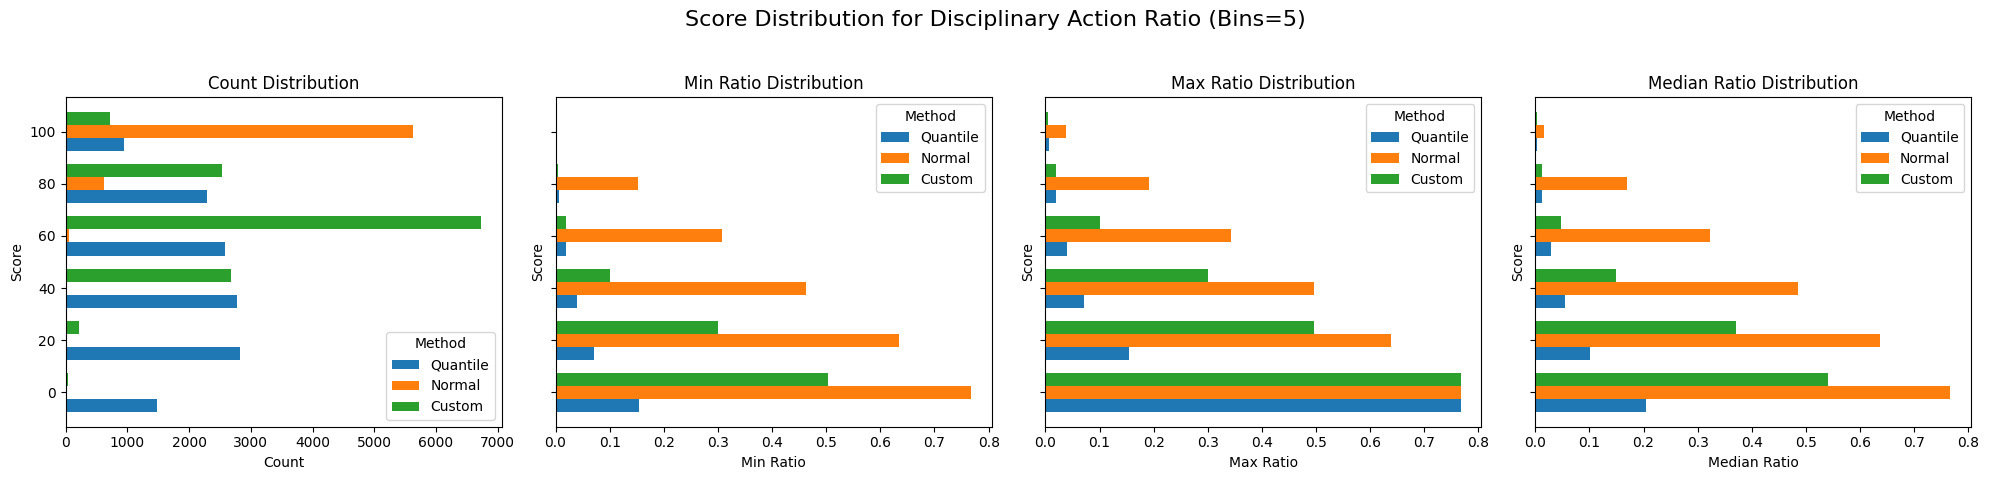

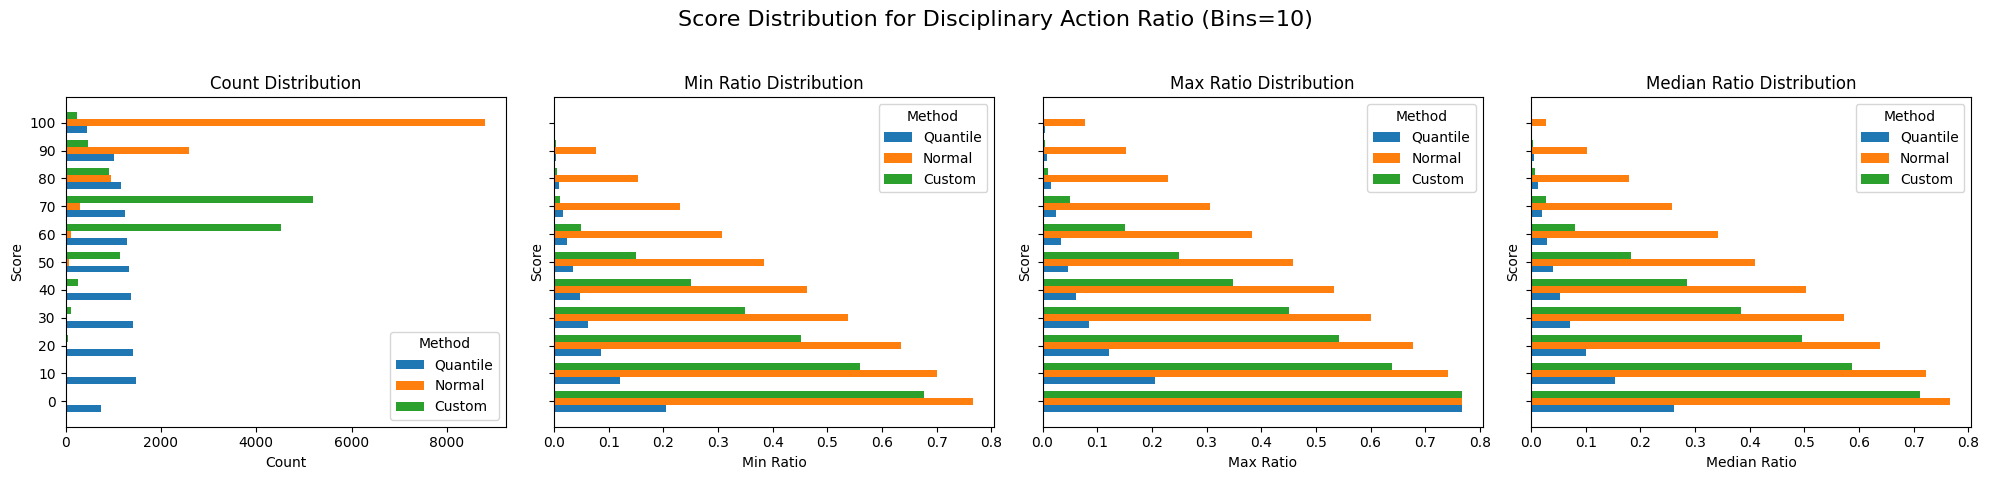

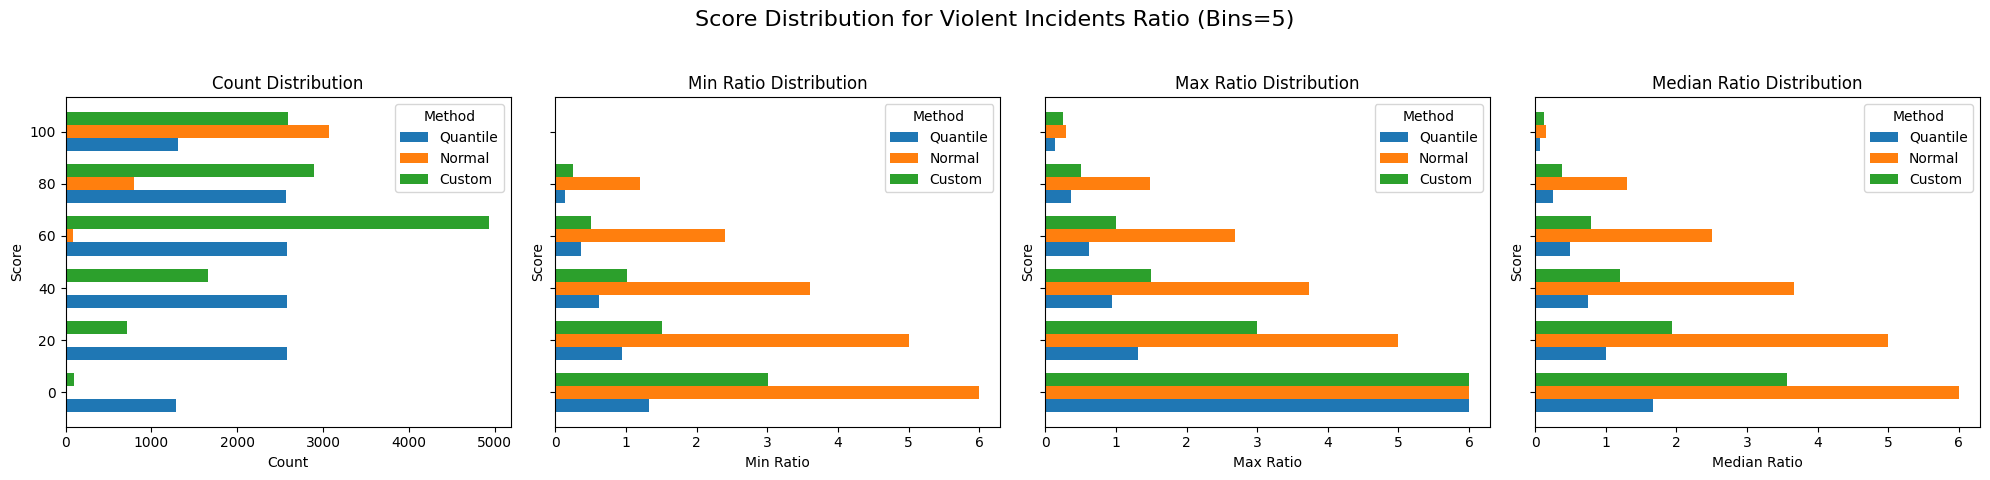

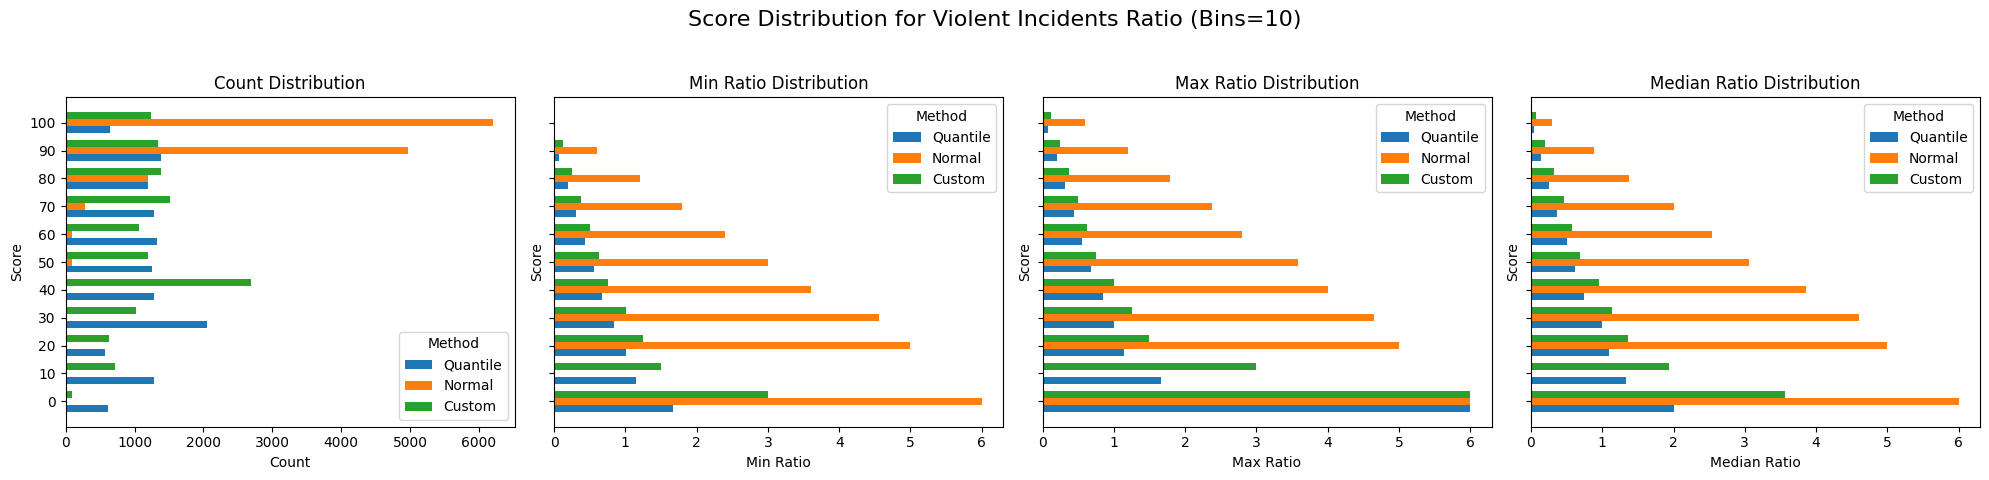

In [87]:
def plot_score_distribution(df, column, bin_size):
    """
    Creates plots for the score distribution of each scoring method (Quantile, Normal, Custom).
    The plots include the count distribution per score, and min, max, and median ratios.
    
    Args:
        df (pd.DataFrame): The input dataframe.
        column (str): The column name to generate distribution plots for.
    """

    df_result = score_distribution_table(df, column, bin_size).replace("N/A", np.nan)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
    fig.suptitle(
        f"Score Distribution for {column.replace('_', ' ').title()} (Bins={bin_size})",
        fontsize=16
    )
    
    # Plot Count Distribution
    bar_width = 0.25
    index = np.arange(len(df_result[("Score", "")]))
    
    for i, method in enumerate(["Quantile", "Normal", "Custom"]):
        axes[0].barh(
            index + i * bar_width,
            df_result[(method, "Count")].values.flatten(),
            height=bar_width,
            label=method
        )
    
    axes[0].set_yticks(index + bar_width)
    axes[0].set_yticklabels(df_result[("Score", "")])
    axes[0].set_title("Count Distribution")
    axes[0].set_xlabel("Count")
    axes[0].set_ylabel("Score")
    axes[0].legend(title="Method")
    
    # Plot Min Ratio Distribution
    for i, method in enumerate(["Quantile", "Normal", "Custom"]):
        axes[1].barh(
            index + i * bar_width,
            df_result[(method, "Min Ratio")].apply(
                lambda x: float(x.strip('%')) / 100 if isinstance(x, str) else x
            ),
            height=bar_width,
            label=method
        )
    
    axes[1].set_yticks(index + bar_width)
    axes[1].set_yticklabels(df_result[("Score", "")])
    axes[1].set_title("Min Ratio Distribution")
    axes[1].set_xlabel("Min Ratio")
    axes[1].set_ylabel("Score")
    axes[1].legend(title="Method")
    
    # Plot Max Ratio Distribution
    for i, method in enumerate(["Quantile", "Normal", "Custom"]):
        axes[2].barh(
            index + i * bar_width,
            df_result[(method, "Max Ratio")].apply(
                lambda x: float(x.strip('%')) / 100 if isinstance(x, str) else x
            ),
            height=bar_width,
            label=method
        )
    
    axes[2].set_yticks(index + bar_width)
    axes[2].set_yticklabels(df_result[("Score", "")])
    axes[2].set_title("Max Ratio Distribution")
    axes[2].set_xlabel("Max Ratio")
    axes[2].set_ylabel("Score")
    axes[2].legend(title="Method")
    
    # Plot Median Ratio Distribution
    for i, method in enumerate(["Quantile", "Normal", "Custom"]):
        axes[3].barh(
            index + i * bar_width,
            df_result[(method, "Median Ratio")].apply(
                lambda x: float(x.strip('%')) / 100 if isinstance(x, str) else x
            ),
            height=bar_width,
            label=method
        )
    
    axes[3].set_yticks(index + bar_width)
    axes[3].set_yticklabels(df_result[("Score", "")])
    axes[3].set_title("Median Ratio Distribution")
    axes[3].set_xlabel("Median Ratio")
    axes[3].set_ylabel("Score")
    axes[3].legend(title="Method")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

for column in columns_to_print:
    plot_score_distribution(report_card_df, column, bin_size=5)
    plot_score_distribution(report_card_df, column, bin_size=10)

### Scoring Findings

When scoring schools based on various performance or metric data, three primary methods were used: **Quantiles**, **Normalization**, and **Custom Scores**. Each method has its own advantages and challenges, depending on the objectives of the analysis and the desired distribution of scores. Below is a detailed comparison of these methods, including their characteristics, benefits, and trade-offs.

---

#### 1. **Quantiles**
Quantiles divide the data into equal-sized bins, ensuring that each bin contains the same number of schools. This results in an **even distribution of schools across the score range**, ensuring that no score range is overrepresented or underrepresented. However, this method has specific drawbacks, particularly in the range between the **minimum and maximum scores**.

##### Key Characteristics:
- **Even Distribution**: Ensures that each score bin has the same number of schools, which prevents bias towards any particular score group.
- **Wide Min/Max Range**: Because quantiles rely on an even count across bins, the minimum and maximum scores can sometimes exhibit large disparities. This occurs if the data is **skewed** or has outliers, leading to wider gaps between extreme scores.
- **Skewed Data Impact**: In cases where data is not normally distributed, some bins may contain a broad range of raw values, distorting the spread of scores.

##### Example:
- **Our data is skewed** towards higher-performing schools, with a larger proportion of schools clustering in the middle to upper range of the scoring distribution. When we apply the quantiles method, we evenly distribute the schools across score bins. However, since the data is skewed, the bins for the lowest scores often contain a few schools with a broad range of performance levels, while the higher bins may represent a more narrow range of performance.
- As a result, the **min/max ratio** for the extreme scores becomes **very wide**. Specifically, a score of **0** (assigned to the lowest-performing schools) has a **dramatic range** of ratios, meaning that some schools may have scores very close to 0, while others in the same bin could have significantly higher scores, distorting the comparison between schools. This leads to a **less interpretable score range at the extremes**, with the low and high ends being more volatile than the middle bins.

##### Conclusion:
Quantiles are useful when we want a **uniform distribution of schools across score bins**, but in this case lead to a **less meaningful interpretation of the extremes** because of the wide min/max ratios. This method is most effective when looking to avoid any score bin being overrepresented or underrepresented, but it may not provide the most intuitive understanding of school performance.

---

#### 2. **Normalization**
Normalization involves scaling the scores such that all schools are converted to a **standardized range** between 0 and 100. This can be particularly useful for ensuring **consistency** across schools, making comparisons simpler.

##### Key Characteristics:
- **Scaling to 100**: All schools are scaled to a score of 100, which helps to create a **unified benchmark** across all schools, regardless of their original ratio distributions.
- **Skewed High**: One of the significant downsides is that most schools will have scores that are clustered near the top (close to 100). This is particularly true if a large portion of schools perform similarly well.
- **Better Distribution for High Scores**: Although normalization results in most schools clustering around the high end of the scale, it **improves the distribution** of scores as they approach the maximum. This means the **min/max ratio** becomes more balanced at higher score levels, giving a clearer picture of high-performing schools.

##### Example:
- The original data shows most schools performing at the upper end of the scale, so normalization will distribute those schools nearer to 100. However, some disparity will exist for the higher scores. Lower-performing schools, in contrast, may end up with similar scores, reducing the contrast between them.

##### Conclusion:
Normalization is a **strong choice for consistency** and can provide a more balanced view of higher-performing schools. However, it lacks **variability at the lower end**, making it harder to distinguish schools with lower performance. If the goal is to focus on the **top-performing schools** or to maintain a consistent scoring approach, normalization works well. However, it sacrifices finer distinctions between schools.

---

#### 3. **Custom Scores**
Custom scores involve creating **user-defined bins** for categorizing schools into score ranges. This method introduces **flexibility** into the process, allowing for a more **logical distribution** of scores, which can often reflect the underlying reality of the data more clearly.

##### Key Characteristics:
- **Logical Distribution**: By defining custom bins based on meaningful intervals or benchmarks, custom scores result in a distribution that is more intuitive and easier to interpret. This often means a **greater concentration of schools** in the middle of the score range, with most schools falling within the 60-80 score range.
- **Arbitrary Binning**: One significant drawback of custom scores is the potential for **subjectivity** in how bins are created. The bins may not always align with statistical significance, leading to **arbitrary decisions** about where to draw the cutoffs.
- **Flexibility**: This method offers the flexibility to adapt scoring bins based on the specific needs of the analysis. For instance, schools that score in the mid-range may be treated as average or typical performers, and the binning can be adjusted accordingly.

##### Example:
- A custom score method might assign a range of 60-80 for most schools, making it easier to interpret and identify trends. However, the choice of where to set the cutoffs for the bins can introduce **bias** if not carefully defined.

##### Conclusion:
Custom scores offer a **practical balance** between flexibility and interpretability. This method may lead to **more logical and consistent results**, especially when the goal is to capture a broader range of performance without too much emphasis on extremes. However, the **arbitrary nature** of binning may introduce challenges in ensuring consistency across datasets or in comparing scores across different periods.

---

### Binning Size (5 vs. 10)

The bin size (i.e., the number of bins used for scoring) plays a critical role in how the data is categorized and interpreted. Let’s examine the pros and cons of using a **bin size of 5** versus **10**.

#### Bin Size 5:
- **Pros**:
  - **Simpler Distribution**: With fewer bins, the scores are more spread out, leading to clearer groupings of schools based on their performance levels.
  - **Easier Interpretation**: Since there are fewer bins, it is easier to interpret the data and compare performance across schools.
  - **Better for Large Datasets**: A smaller bin size works well for large datasets, where a finer granularity might make the analysis harder to interpret.
  
- **Cons**:
  - **Less Precision**: The larger size of the bins means there’s less differentiation between schools in the same bin. This can obscure small differences in performance.
  - **Potential Over-generalization**: With fewer bins, the scoring can become overly generalized, losing some of the nuance in the data.

#### Bin Size 10:
- **Pros**:
  - **Increased Precision**: With more bins, there’s more granularity in the scoring system, allowing for finer distinctions between schools.
  - **Better for Small Datasets**: Because the dataset contains significant variance, a larger number of bins can provide a more detailed picture of school performance.
  
- **Cons**:
  - **More Complexity**: With 10 bins, the data becomes more complex to interpret, making it harder for a general audience to understand.
  - **Potential for Overfitting**: More bins can lead to overfitting in some cases, where small variations in the data are treated as significant.
  - **Less Intuitive**: The finer granularity may cause difficulties in drawing meaningful conclusions from the scores, especially when most schools fall into similar score ranges.

---

### Summary of Trade-offs:
| Method         | Key Strengths                                    | Key Drawbacks                                  | Best Use Case                               |
|----------------|--------------------------------------------------|------------------------------------------------|---------------------------------------------|
| **Quantiles**  | - Even distribution of schools across bins       | - Wide range for min/max at extremes          | When you need even distribution across all bins, and consistency is more important than extreme values. |
| **Normalization** | - Scaling to 100 provides consistency          | - Most schools clustered near 100; less contrast | Ideal for highlighting top-performing schools, or when you need uniformity in scoring across all schools. |
| **Custom Scores** | - Logical distribution, intuitive interpretation | - Subjectivity in binning, arbitrary ranges    | When interpretability and flexibility in defining score ranges are crucial, but beware of subjective binning. |
| **Bin Size 5** | - Simpler distribution, easier interpretation    | - Less precision, potential over-generalization | Best for large datasets or when ease of interpretation is prioritized over precision. |
| **Bin Size 10** | - Increased precision, more granularity          | - More complexity, potential overfitting      | Best for smaller datasets or when finer distinctions between schools are needed. |

---

### Conclusion:
Each method and bin size offers distinct advantages. The **best choice** depends on your specific objectives:

- **Quantiles** are ideal for ensuring even distribution, but they may result in less meaningful interpretation of extreme scores.
- **Normalization** is useful for creating consistency across schools but sacrifices variability at the lower end.
- **Custom scores** provide flexibility and logical distribution but may suffer from subjective binning.
- The choice of **bin size** (5 vs. 10) impacts the precision and complexity of the analysis. **Smaller bins (5)** are simpler and easier to interpret, while **larger bins (10)** offer more precision but can complicate the analysis.

For most cases, **custom scores with a bin size of 5** offer the best balance of interpretability and flexibility. However, if **precision** or **fine distinctions** are essential, **bin size 10** might be preferable, with careful consideration of how the bins are defined.

In [88]:
# EXTRA:

    # # All Schools: Disciplinary-to-Violence Ratio
    # axes[2, 0].hist(
    #     report_card_df['disciplinary_to_violence_ratio'].dropna(), bins=10,
    #     color='orange', edgecolor='black', alpha=0.7
    # )
    # axes[2, 0].set_title("All Schools - Disciplinary-to-Violence Ratio")
    # axes[2, 0].set_xlabel("Ratio")
    # axes[2, 0].set_ylabel("Frequency")
    # axes[2, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # # RSSI Schools: Disciplinary-to-Violence Ratio
    # axes[2, 1].hist(
    #     rssi_schools_df['disciplinary_to_violence_ratio'].dropna(), bins=10,
    #     color='cyan', edgecolor='black', alpha=0.7
    # )
    # axes[2, 1].set_title("RSSI Schools - Disciplinary-to-Violence Ratio")
    # axes[2, 1].set_xlabel("Ratio")
    # axes[2, 1].set_ylabel("Frequency")
    # axes[2, 1].grid(axis='y', linestyle='--', alpha=0.7)

# report_card_df = calculate_disciplinary_to_violence_ratio(
#     report_card_df, ['num_stdnts_with_discipline_incidents'],
#     ['num_disc_incdts_violent', 'num_disc_incdts_other'],
#     'disciplinary_to_violence_ratio'
# )

# report_card_df['disciplinary_to_violence_ratio'] = pd.to_numeric(
#     report_card_df['disciplinary_to_violence_ratio'], errors='coerce'
# )

# rssi_schools_df = calculate_disciplinary_to_violence_ratio(
#     rssi_schools_df, ['num_stdnts_with_discipline_incidents'],
#     ['num_disc_incdts_violent', 'num_disc_incdts_other'],
#     'disciplinary_to_violence_ratio'
# )

# rssi_schools_df['disciplinary_to_violence_ratio'] = pd.to_numeric(
#     rssi_schools_df['disciplinary_to_violence_ratio'], errors='coerce'
# )

# all_schools_disciplinary_to_violence_quantiles = (
#     report_card_df['disciplinary_to_violence_ratio'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
#                                                     .round(3)
# )

# rssi_disciplinary_to_violence_quantiles = (
#     rssi_schools_df['disciplinary_to_violence_ratio'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
#                                                      .round(3)
# )

# def granular_rescale(df, column):
#     low_threshold = df[column].quantile(0.25)
#     high_threshold = df[column].quantile(0.75)

#     def rescale_low(x):
#         return 100 * (1 - (x - low_threshold) / (high_threshold - low_threshold))

#     def rescale_mid(x):
#         return 100 * (1 - (x - low_threshold) / (high_threshold - low_threshold))

#     def rescale_high(x):
#         return 100 * (1 - (x - high_threshold) / (df[column].max() - high_threshold))

#     df[column + '_score_granular'] = df[column].apply(
#         lambda x: rescale_low(x) if x <= low_threshold
#         else rescale_mid(x) if x <= high_threshold
#         else rescale_high(x))

#     bins = [float('-inf'), 0, 20, 40, 60, 80, 100]
#     labels = [0, 20, 40, 60, 80, 100]
#     df[column + '_score_granular'] = pd.cut(
#       df[column + '_score_granular'], bins=bins, labels=labels, right=True, include_lowest=True
#     )

#     return df

    # 'disciplinary_to_violence_ratio': {
    #     'bins': [0.2, 0.6, 1.0, 3.0, 5.0, 7.0, float('inf')],
    #     'scores': [100, 80, 60, 40, 20, 0],
    # },